# Bank customers churn modeling

## Прогнозирование оттока клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Содержание:

1. Импорт библиотек и загрузка данных
2. EDA
3. Подготовка и разбиение данных
4. Модели. Подбор гиперпараметров. Upsampling/downsampling
6. Проверка на вменяемость
7. Сравнение результатов моделей
8. Выводы

### 1. Импорт библиотек и загрузка данных

In [53]:
import pandas as pd
import numpy as np
# graphs
import seaborn as sns
import matplotlib.pyplot as plt
# split & scaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import roc_curve
# grid_search
from sklearn.model_selection import GridSearchCV
# KFold
from sklearn.model_selection import KFold
from itertools import product
# dummy
from sklearn.dummy import DummyClassifier
import warnings

In [54]:
# включим игнорирование предупреждений для того, чтобы лучше читалось
warnings.filterwarnings('ignore')

In [55]:
# заводим константу RANDOM_STATE
RANDOM_STATE = 12345
# cross-validation
CV_K = 5


In [56]:
try:
    df = pd.read_csv('datasets/Churn.csv')
except FileNotFoundError:
    df = pd.read_csv('Churn.csv')

In [57]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [59]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


#### Описание данных
Данные находятся в файле /datasets/Churn.csv

Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак
- Exited — факт ухода клиента

### 2. EDA

**Target 'Exited'**

Неравномерное целевого признака: 80-20.
Понадобится балансировка.

In [60]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

**'RowNumber'**

Столбец, повторяющий индексацию со сдвигом на единицу. Не несет новой информации.

In [61]:
df['RowNumber'].value_counts().count()

10000

**'CustomerId'**

Еще один столбец с уникальными номерами (они все разные и их ровно 10000). Это некий уникальный номер, присваиваемый клиенту. Тоже сомнительно, что столбец несет полезную информацию, и от него может зависеть уход клиента. Этот столбец помогает понять, что дубликатов в этом фрейме нет.

In [62]:
df['CustomerId'].value_counts().count()

10000

**'Surname'**

2932 разных фамилии, есть повторяющиеся. Фамилия не должна быть параметром, от которого зависит, что уход клиента.

In [63]:
df['Surname'].value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64

**'CreditScore'**

Text(0, 0.5, 'Clients')

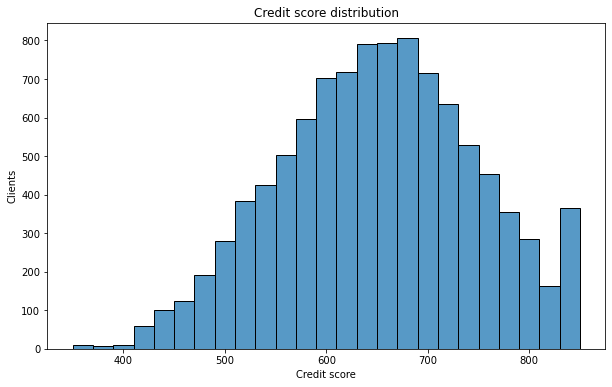

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='CreditScore', bins=25, ax=ax)
plt.title('Credit score distribution')
plt.xlabel('Credit score')
plt.ylabel('Clients')

**'Age'**

 - распределение адекватное, похоже на нормальное
 - возраст начинается с 18 лет (это понятно, клиенты совершеннолетние)

Text(0, 0.5, 'Clients')

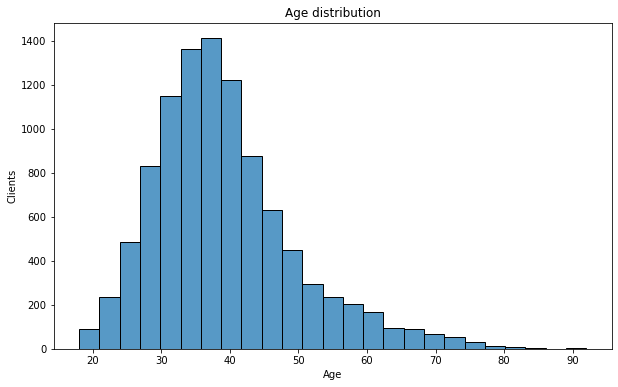

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='Age', bins=25, ax=ax)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Clients')

**'Geography'**

Категориальный признак. Три значения. Будем кодировать его методом One-Hot Encoding.

In [66]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

**'Gender'**

Категориальный признак. Два значения. One-Hot Encoding.

In [67]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

**'Tenure'**

Сколько лет человек был клиентом банка.

Распределение вполне равномерное.

Есть пропущенные данные (их ~9% (909/10000)).

Если сравнить распределение у пропущенных данных и у оставшихся, то не видно сильных различий.
Удалять просто так 9% данных не хочется. Можно заменить на значение медианы

Text(0, 0.5, 'Clients')

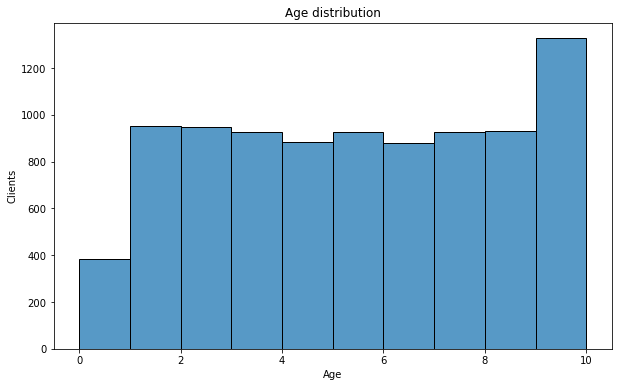

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='Tenure', bins=10, ax=ax)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Clients')

**'Balance'**

Распределение данных адекватное. Пик в нуле понятен (у людей ноль на счетах, например, новые клиенты)

Посмотрим распределение данных у двух категорий: с нулевым балансом и остальных (в каком-то смысле, неактивные пользователи и активные).
Между этими категориями видны различия по количеству продуктов ('num_of_products') и по целевому признаку ('exited').

Text(0, 0.5, 'Clients')

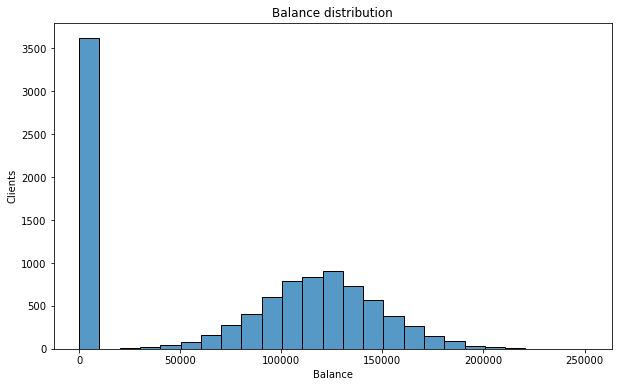

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='Balance', bins=25, ax=ax)
plt.title('Balance distribution')
plt.xlabel('Balance')
plt.ylabel('Clients')

**'NumOfProducts'**

Большая часть клиентов пользуется одним или двумя продуктами.

In [70]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

**'EstimatedSalary'**

Распределение по предполагаемой зарплате равномерное.

Text(0, 0.5, 'Clients')

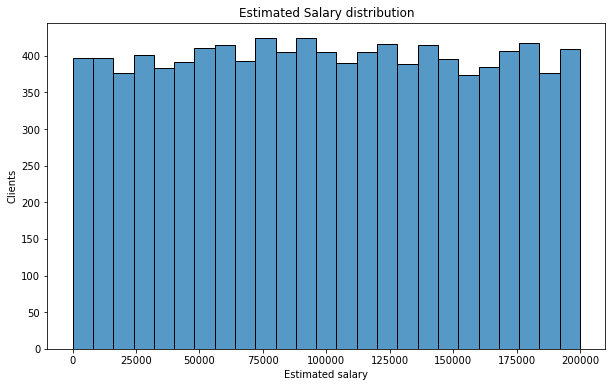

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=df, x='EstimatedSalary', bins=25, ax=ax)
plt.title('Estimated Salary distribution')
plt.xlabel('Estimated salary')
plt.ylabel('Clients')

**Корреляция признаков**

- видны некоторые интересные расслоения (особенно по признакам 'age', 'num_of_products')
- какой-то значичимой корреляции между признаками не видно (максимум 0.28 между 'age' и 'exited')

Text(0.5, 1.0, 'Корреляция между признаками')

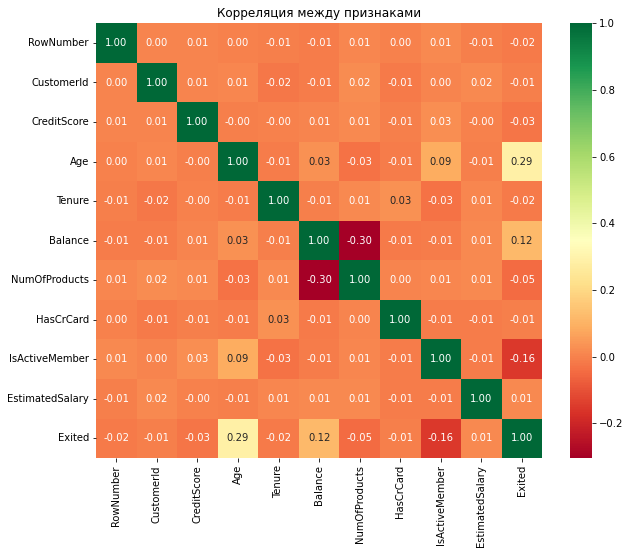

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='RdYlGn')
plt.title('Корреляция между признаками')

### 3. Подготовка и разбиение данных

**Удаление "лишних" признаков**

Признаки 'CustomerId', 'RowNumber', 'Surname' не должны влиять на нашу модель. Их можно удалить.

In [73]:
# создание датафрейма X - очищенный датафрейм для моделей.
df_clean = df.drop(['CustomerId', 'RowNumber', 'Surname'] , axis=1)

**Обработка пропусков**

В данных 9% пропусков в стобце 'Tenure'. Заменим пропущенные данные на медиану (=5)

In [74]:
df_clean = df_clean.fillna(df_clean['Tenure'].median())

**OneHotEncoding категориальных признаков**

In [75]:
cat_cols = ['Geography', 'Gender']
num_cols = ['CreditScore','Age', 'Tenure', 'Balance', \
            'NumOfProducts', 'HasCrCard', 'IsActiveMember', \
            'EstimatedSalary']

In [76]:
enc = OneHotEncoder(drop='first')
enc.fit(df_clean[cat_cols])
ohe_columns = enc.get_feature_names_out (df_clean[cat_cols].columns)
df_clean_ohe = pd.DataFrame(enc.transform(df_clean[cat_cols]).toarray(), 
                     columns=ohe_columns,
                     index=df_clean.index)

In [77]:
df_clean[num_cols]
df_clean_ohe

,Geography_Germany,Geography_Spain,Gender_Male
0,0.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
9995,0.0,0.0,1.0
9996,0.0,0.0,1.0
9997,0.0,0.0,0.0
9998,1.0,0.0,1.0


In [78]:
df_clean_ohe = df_clean[num_cols].join(df_clean_ohe)
df_clean_ohe

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0.0,0.0,0.0
1,608,41,1.0,83807.86,1,0,1,112542.58,0.0,1.0,0.0
2,502,42,8.0,159660.80,3,1,0,113931.57,0.0,0.0,0.0
3,699,39,1.0,0.00,2,0,0,93826.63,0.0,0.0,0.0
4,850,43,2.0,125510.82,1,1,1,79084.10,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0.0,0.0,1.0
9996,516,35,10.0,57369.61,1,1,1,101699.77,0.0,0.0,1.0
9997,709,36,7.0,0.00,1,0,1,42085.58,0.0,0.0,0.0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1.0,0.0,1.0


**Разделение выборки и масштабирование признаков**

In [79]:
X = df_clean_ohe.copy()
y = df_clean['Exited'].copy()

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

In [81]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

### 4. Модели. Подбор гиперпараметров

Исследуем несколько моделей:
- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier

Каждую модель обучаем в следующих ситуациях:
1. без учета дисбаланса классов (подбор гиперпараметров и кроссвалидация - GridSearchCV)
2. с учетом дисбаланса классов
    1. class_weight='balanced' (подбор гиперпараметров и кроссвалидация - GridSearchCV) 
    2. upsampling (подбор гиперпараметров и кросвалидация с помощью KFold)
    3. downsampling (подбор гиперпараметров и кросвалидация с помощью KFold)

При применении upsampling/downsampling для решения проблемы дисбаланса классов Grid/RandomSearchCV не корректно, поэтому сделаем кросс-валидацию вручную с использование KFold.

In [82]:
# датафрейм для репорта по моделям
models_report_indexes = ['LogisticRegression_1',
                         'LogisticRegression_2',
                         'LogisticRegression_3',
                         'LogisticRegression_4',
                         'DecisionTreeClassifier_1',
                         'DecisionTreeClassifier_2',
                         'DecisionTreeClassifier_3',
                         'DecisionTreeClassifier_4',  
                         'RandomForestClassifier_1', 
                         'RandomForestClassifier_2',
                         'RandomForestClassifier_3',
                         'RandomForestClassifier_4'                         
                         ]
models_report_columns = ['balance', 'F1-score', 'ROC-AUC']
models_report = pd.DataFrame(columns=models_report_columns,
                             index=models_report_indexes)

In [83]:
def upsample(X, y, repeat):
    X_zeros = X[y == 0]
    X_ones  = X[y == 1]
    y_zeros = y[y == 0]
    y_ones  = y[y == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)

    return shuffle(X_upsampled, y_upsampled, random_state=RANDOM_STATE)  

def downsample(X, y, fraction):
    X_zeros = X[y == 0]
    X_ones  = X[y == 1]
    y_zeros = y[y == 0]
    y_ones  = y[y == 1]

    X_zeros_downsampled = X_zeros.sample(frac=fraction, random_state=RANDOM_STATE)
    y_zeros_downsampled = y_zeros.sample(frac=fraction, random_state=RANDOM_STATE)

    X_downsampled = pd.concat([X_zeros_downsampled] + [X_ones])
    y_downsampled = pd.concat([y_zeros_downsampled] + [y_ones])
    
    return shuffle(X_downsampled, y_downsampled, random_state=RANDOM_STATE)

In [84]:
# создаем объект kfold
kfold = KFold(n_splits=CV_K, shuffle=False)

In [85]:
# function for cross-validation of transformed sample(upsampling, downsampling) 
def cv_transformed_model(model, params, X, y, kfold, transform, transofm_rate):
    f1_scores = []
    roc_auc_scores = []    

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # tarnsformation
        X_train_transformed, y_train_transformed = transform(X_train, y_train, transofm_rate)
        
        model_obj = model(**params).fit(X_train_transformed, y_train_transformed)
        
        y_pred = model_obj.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
          
        f1_scores.append(f1)
        roc_auc_scores.append(roc_auc)
        
    return np.array(f1_scores).mean(), np.array(roc_auc_scores).mean()

In [86]:
def print_results(model, X_train, X_test, y_train, y_test):
    print(f'Train. Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Train. F1-score: {f1_score(y_train, model.predict(X_train))}')
    print(f'Train. ROC-AUC : {roc_auc_score(y_train, model.predict(X_train))}')
    print(f'Test.  Accuracy: {accuracy_score(y_test, model.predict(X_test))}')
    print(f'Test.  F1-score: {f1_score(y_test, model.predict(X_test))}')
    print(f'Test.  ROC-AUC : {roc_auc_score(y_test, model.predict(X_test))}')

def fill_report(report, model_name, balance_type, model, X_test, y_test):
    report.loc[model_name, 'balance'] = balance_type
    report.loc[model_name, 'Accuracy'] = round(accuracy_score(y_test, model.predict(X_test)), 3)
    report.loc[model_name, 'F1-score'] = round(f1_score(y_test, model.predict(X_test)), 3)
    report.loc[model_name, 'ROC-AUC'] = round(roc_auc_score(y_test, model.predict(X_test)), 3)
    report.loc[model_name]
    

#### 3.1 LogisticRegression

Без учета дисбаланса классов

In [87]:
# без учета дисбаланса классов
lr_params_1 = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'max_iter':  [100, 1000],
    'class_weight': [None],
    'solver': ['lbfgs', 'liblinear'],
}
lr_1 = LogisticRegression(random_state=RANDOM_STATE)
lr_grid_search_1 = GridSearchCV(lr_1,
                              lr_params_1,
                              cv=5)

lr_grid_search_1.fit(X_train, y_train)

print("Best parameters: ", lr_grid_search_1.best_params_)
    
print_results(lr_grid_search_1.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'LogisticRegression_1', 'none', lr_grid_search_1.best_estimator_, X_test, y_test)

Best parameters:  {'C': 0.03359818286283781, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Train. Accuracy: 0.8136
Train. F1-score: 0.301
Train. ROC-AUC : 0.5841779526095602
Test.  Accuracy: 0.8132
Test.  F1-score: 0.30402384500745155
Test.  ROC-AUC : 0.5851286585311702


С учетов дисбаланса классов. class_weight='balanced'

In [88]:
# С учетом дисбаланса классов. class_weight='balanced'
lr_params_2 = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'max_iter':  [100, 1000],
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'liblinear'],
}
lr_2 = LogisticRegression(random_state=RANDOM_STATE)
lr_grid_search_2 = GridSearchCV(lr_2,
                              lr_params_2,
                              cv=5)

lr_grid_search_2.fit(X_train, y_train)

print("Best parameters: ", lr_grid_search_2.best_params_)
    
print_results(lr_grid_search_2.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'LogisticRegression_2', 'balanced', lr_grid_search_2.best_estimator_, X_test, y_test)

Best parameters:  {'C': 0.0001, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Train. Accuracy: 0.7962666666666667
Train. F1-score: 0.0
Train. ROC-AUC : 0.5
Test.  Accuracy: 0.7964
Test.  F1-score: 0.0
Test.  ROC-AUC : 0.5


Upsampling

In [89]:
# upsampling
lr_params_3 = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l2'],
    'max_iter':  [100, 1000],
    'class_weight': [None],
    'solver': ['lbfgs', 'liblinear'],
}

lr_models_3 = []

for C, penalty, max_iter, solver in product(lr_params_3['C'],
                                            lr_params_3['penalty'],
                                            lr_params_3['max_iter'],
                                            lr_params_3['solver']
                                           ):
    params = {'C': C,
              'penalty': penalty,
              'max_iter': max_iter,
              'solver': solver,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(LogisticRegression,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           upsample, 
                                                           2
                                                           )
    lr_models_3.append(params)


best_params = sorted(lr_models_3, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
lr_3 = LogisticRegression(**best_params).fit(X_train, y_train)

print("Best parameters: ", best_params)
print_results(lr_3, X_train, X_test, y_train, y_test)
fill_report(models_report, 'LogisticRegression_3', 'upsampled', lr_3, X_test, y_test)

Best parameters:  {'C': 0.615848211066026, 'penalty': 'l2', 'max_iter': 100, 'solver': 'lbfgs', 'random_state': 12345}
Train. Accuracy: 0.8121333333333334
Train. F1-score: 0.3150218765192027
Train. ROC-AUC : 0.5888575130714714
Test.  Accuracy: 0.8136
Test.  F1-score: 0.3206997084548105
Test.  ROC-AUC : 0.5912292941024394


downsampling

In [90]:
# downsampling
lr_params_4 = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l2'],
    'max_iter':  [100, 1000],
    'class_weight': [None],
    'solver': ['lbfgs', 'liblinear'],
}

lr_models_4 = []

for C, penalty, max_iter, solver in product(lr_params_4['C'],
                                            lr_params_4['penalty'],
                                            lr_params_4['max_iter'],
                                            lr_params_4['solver']
                                           ):
    params = {'C': C,
              'penalty': penalty,
              'max_iter': max_iter,
              'solver': solver,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(LogisticRegression,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           downsample, 
                                                           0.4
                                                           )
    lr_models_4.append(params)

best_params = sorted(lr_models_4, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
lr_4 = LogisticRegression(**best_params).fit(X_train, y_train)

print("Best parameters: ", best_params)
print_results(lr_4, X_train, X_test, y_train, y_test)
fill_report(models_report, 'LogisticRegression_4', 'downsampled', lr_4, X_test, y_test)

Best parameters:  {'C': 1.623776739188721, 'penalty': 'l2', 'max_iter': 100, 'solver': 'lbfgs', 'random_state': 12345}
Train. Accuracy: 0.8122666666666667
Train. F1-score: 0.316504854368932
Train. ROC-AUC : 0.5894282392877056
Test.  Accuracy: 0.8132
Test.  F1-score: 0.3202328966521106
Test.  ROC-AUC : 0.5909781640170552


#### 3.2 DecisionTreeClassifier

Без учета дисбаланса классов

In [91]:
dt_1 = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_params_1 = {
    'max_depth': [None, 8, 10, 12, 15],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4],
    'class_weight': [None, 'balanced']
}

dt_grid_search_1 = GridSearchCV(dt_1,
                              dt_params_1,
                              cv=5)

dt_grid_search_1.fit(X_train, y_train)

print("Best parameters: ", dt_grid_search_1.best_params_)
print_results(dt_grid_search_1.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'DecisionTreeClassifier_1', 'none', dt_grid_search_1.best_estimator_, X_test, y_test)

Best parameters:  {'class_weight': None, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 4}
Train. Accuracy: 0.8830666666666667
Train. F1-score: 0.6628219915417146
Train. ROC-AUC : 0.7644022892170443
Test.  Accuracy: 0.8484
Test.  F1-score: 0.5678449258836944
Test.  ROC-AUC : 0.7147127693481177


С учетов дисбаланса классов. class_weight='balanced'

In [92]:
dt_2 = DecisionTreeClassifier(random_state=RANDOM_STATE)

dt_params_2 = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4],
    'class_weight': ['balanced']
}

dt_grid_search_2 = GridSearchCV(dt_2,
                              dt_params_2,
                              cv=5)

dt_grid_search_2.fit(X_train, y_train)

print("Best parameters: ", dt_grid_search_2.best_params_)
print_results(dt_grid_search_2.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'DecisionTreeClassifier_2', 'balanced', dt_grid_search_2.best_estimator_, X_test, y_test)


Best parameters:  {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train. Accuracy: 0.9565333333333333
Train. F1-score: 0.9013914095583787
Train. ROC-AUC : 0.9634529199089642
Test.  Accuracy: 0.7892
Test.  F1-score: 0.5187214611872145
Test.  ROC-AUC : 0.7031371032119982


Upsampling

In [93]:
# upsampling
dt_params_3 = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4]
}

dt_models_3 = []

for max_depth, min_samples_leaf, min_samples_split in product(dt_params_3['max_depth'],
                                                              dt_params_3['min_samples_leaf'],
                                                              dt_params_3['min_samples_split']                                                              
                                                            ):
    params = {'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(DecisionTreeClassifier,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           upsample, 
                                                           2
                                                           )
    dt_models_3.append(params)

best_params = sorted(dt_models_3, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
dt_3 = DecisionTreeClassifier(**best_params).fit(X_train, y_train)

print("Best parameters: ", best_params)
print_results(dt_3, X_train, X_test, y_train, y_test)
fill_report(models_report, 'DecisionTreeClassifier_3', 'upsampled', dt_3, X_test, y_test)

Best parameters:  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 12345}
Train. Accuracy: 0.8810666666666667
Train. F1-score: 0.6566589684372595
Train. ROC-AUC : 0.7609549187657585
Test.  Accuracy: 0.848
Test.  F1-score: 0.5642201834862385
Test.  ROC-AUC : 0.7122680747055266


Downsampling

In [94]:
# downsampling
dt_params_4 = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 4]
}

dt_models_4 = []

for max_depth, min_samples_leaf, min_samples_split in product(dt_params_4['max_depth'],
                                                              dt_params_4['min_samples_leaf'],
                                                              dt_params_4['min_samples_split']                                                              
                                                            ):
    params = {'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(DecisionTreeClassifier,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           downsample, 
                                                           0.4
                                                           )
    dt_models_4.append(params)

best_params = sorted(dt_models_4, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
dt_4 = DecisionTreeClassifier(**best_params).fit(X_train, y_train)

print("Best parameters: ", best_params)
print_results(dt_4, X_train, X_test, y_train, y_test)
fill_report(models_report, 'DecisionTreeClassifier_4', 'downsampled', dt_4, X_test, y_test)

Best parameters:  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12345}
Train. Accuracy: 0.8834666666666666
Train. F1-score: 0.6643625192012288
Train. ROC-AUC : 0.7653839646097145
Test.  Accuracy: 0.8496
Test.  F1-score: 0.5697940503432495
Test.  ROC-AUC : 0.7154661596042703


#### 3.3 RandomForestClassifier

Без учета дисбаланса классов

In [95]:
rf_1 = RandomForestClassifier(random_state=RANDOM_STATE)

rf_params_1 = {
    'n_estimators': [50],
    'max_depth': [5, 10, 14, 1],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4],
    'class_weight': [None]
}

rf_grid_search_1 = GridSearchCV(rf_1,
                              rf_params_1,
                              cv=5)

rf_grid_search_1.fit(X_train, y_train)

print("Best parameters: ", rf_grid_search_1.best_params_)
print_results(rf_grid_search_1.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'RandomForestClassifier_1', 'none', rf_grid_search_1.best_estimator_, X_test, y_test)

Best parameters:  {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Train. Accuracy: 0.8901333333333333
Train. F1-score: 0.657522859517872
Train. ROC-AUC : 0.7515510865715398
Test.  Accuracy: 0.8648
Test.  F1-score: 0.5796019900497513
Test.  ROC-AUC : 0.7133100918771011


С учетов дисбаланса классов. class_weight='balanced'

In [96]:
rf_2 = RandomForestClassifier(random_state=RANDOM_STATE)

rf_params_2 = {
    'n_estimators': [50, 55],
    'max_depth': [5, 10, 14, 1],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4],
    'class_weight': ['balanced']
}

rf_grid_search_2 = GridSearchCV(rf_2,
                                rf_params_2,
                                cv=5)

rf_grid_search_2.fit(X_train, y_train)

print("Best parameters: ", rf_grid_search_2.best_params_)
print_results(rf_grid_search_2.best_estimator_, X_train, X_test, y_train, y_test)
fill_report(models_report, 'RandomForestClassifier_2', 'balanced', rf_grid_search_2.best_estimator_, X_test, y_test)

Best parameters:  {'class_weight': 'balanced', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Train. Accuracy: 0.9682666666666667
Train. F1-score: 0.9236200256739409
Train. ROC-AUC : 0.9584020805644491
Test.  Accuracy: 0.8508
Test.  F1-score: 0.6027689030883919
Test.  ROC-AUC : 0.7410799481754339


Upsampling

In [97]:
# upsampling
rf_params_3 = {
    'n_estimators': [50, 45],
    'max_depth': [5, 10, 14, 1],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4]
}

rf_models_3 = []

for n_estimators, max_depth, min_samples_leaf, min_samples_split in product(rf_params_3['n_estimators'],
                                                                            rf_params_3['max_depth'],
                                                                            rf_params_3['min_samples_leaf'],
                                                                            rf_params_3['min_samples_split']                                                              
                                                                            ):
    params = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(RandomForestClassifier,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           upsample, 
                                                           2
                                                           )
    rf_models_3.append(params)

best_params = sorted(rf_models_3, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
rf_3 = RandomForestClassifier(**best_params).fit(X_train, y_train)



print("Best parameters: ", best_params)
print_results(rf_3, X_train, X_test, y_train, y_test)
fill_report(models_report, 'RandomForestClassifier_3', 'upsampled', rf_3, X_test, y_test)

Best parameters:  {'n_estimators': 45, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 12345}
Train. Accuracy: 0.8966666666666666
Train. F1-score: 0.6814632141389231
Train. ROC-AUC : 0.7649066060463665
Test.  Accuracy: 0.8632
Test.  F1-score: 0.5725
Test.  ROC-AUC : 0.7093808187926218


Downsampling

In [98]:
# dowsampling
rf_params_4 = {
    'n_estimators': [50],
    'max_depth': [5, 10, 14, 1],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 4]
}

rf_models_4 = []

for n_estimators, max_depth, min_samples_leaf, min_samples_split in product(rf_params_4['n_estimators'],
                                                                            rf_params_4['max_depth'],
                                                                            rf_params_4['min_samples_leaf'],
                                                                            rf_params_4['min_samples_split']                                                              
                                                                            ):
    params = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'min_samples_split': min_samples_split,
              'random_state': RANDOM_STATE
             }
    
    params['f1'], params['roc_auc'] = cv_transformed_model(RandomForestClassifier,
                                                           params, 
                                                           X_train, 
                                                           y_train, 
                                                           kfold,
                                                           downsample, 
                                                           0.4
                                                           )
    rf_models_4.append(params)

best_params = sorted(rf_models_4, key=lambda x: x['f1'], reverse=True)[0]
del best_params['f1']
del best_params['roc_auc']
rf_4 = RandomForestClassifier(**best_params).fit(X_train, y_train)

print("Best parameters: ", best_params)
print_results(rf_4, X_train, X_test, y_train, y_test)
fill_report(models_report, 'RandomForestClassifier_4', 'downsampled', rf_4, X_test, y_test)

Best parameters:  {'n_estimators': 50, 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'random_state': 12345}
Train. Accuracy: 0.8901333333333333
Train. F1-score: 0.657522859517872
Train. ROC-AUC : 0.7515510865715398
Test.  Accuracy: 0.8648
Test.  F1-score: 0.5796019900497513
Test.  ROC-AUC : 0.7133100918771011


### 5. Проверка моделей на вменяемость

In [99]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.predict(X_test)

print_results(dummy, X_train, X_test, y_train, y_test)
fill_report(models_report, 'Dummy', 'none', dummy, X_test, y_test)

Train. Accuracy: 0.7962666666666667
Train. F1-score: 0.0
Train. ROC-AUC : 0.5
Test.  Accuracy: 0.7964
Test.  F1-score: 0.0
Test.  ROC-AUC : 0.5


### 6. Сравнение результатов моделей 

Лучший результат по метрике F1-score:

    - RandomForestClassifier с гиперпараметрами  
    - {'class_weight': 'balanced', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Результаты на тестовой выборке: **F1-score 0.603**, ROC-AUC 0.781, Accuracy 0.851

Контрольный результат F1-score > 0.59 достигнут.

In [100]:
models_report.sort_values(by='F1-score', ascending=False)

,balance,F1-score,ROC-AUC,Accuracy
RandomForestClassifier_2,balanced,0.603,0.741,0.851
RandomForestClassifier_1,none,0.58,0.713,0.865
RandomForestClassifier_4,downsampled,0.58,0.713,0.865
RandomForestClassifier_3,upsampled,0.572,0.709,0.863
DecisionTreeClassifier_4,downsampled,0.57,0.715,0.850
DecisionTreeClassifier_1,none,0.568,0.715,0.848
DecisionTreeClassifier_3,upsampled,0.564,0.712,0.848
DecisionTreeClassifier_2,balanced,0.519,0.703,0.789
LogisticRegression_3,upsampled,0.321,0.591,0.814
LogisticRegression_4,downsampled,0.32,0.591,0.813


In [101]:
model = RandomForestClassifier(random_state=12345, 
                               class_weight='balanced', 
                               max_depth=14,
                               min_samples_leaf=2,
                               min_samples_split=2,
                               n_estimators=50) 

model.fit(X_train, y_train)

print_results(model, X_train, X_test, y_train, y_test)


Train. Accuracy: 0.9682666666666667
Train. F1-score: 0.9236200256739409
Train. ROC-AUC : 0.9584020805644491
Test.  Accuracy: 0.8508
Test.  F1-score: 0.6027689030883919
Test.  ROC-AUC : 0.7410799481754339


In [102]:
model.predict_proba(X_test)

array([[0.94418831, 0.05581169],
       [0.25895162, 0.74104838],
       [0.74687928, 0.25312072],
       ...,
       [0.84576926, 0.15423074],
       [0.91850477, 0.08149523],
       [0.85982017, 0.14017983]])

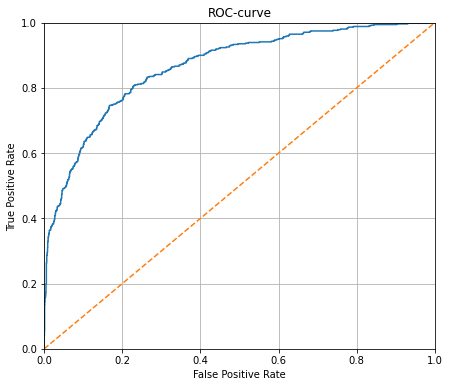

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1]) 

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')

plt.show()

### 7. Выводы

**Проведено исследование**

- загружены и изучены данные, проведена предобработка (удалены бессмысленные с точки зрения предсказаний признаки, заполнены пропуски), обнаружен дисбаланс в значения целевого признака (80/20)
- проведено разбиение на тренировочную и тестовую выборки, проведено кодирование категориальных признаков и масштабирование численных
- исследованы три модели (LogisticRegression, DecisionTreeClassifier, RandomForestClassifier) с различными гиперпараметрами; 
- проведен поиск лучшей модели по гиперпараметрам с использованием кросс-валидации.
- исследованы способы устранения дисбаланса классов (взвешивание классов, upsampling, downsampling)
- проведена проверка результата на вменяемость: сравнение с dummy-моделью

**Найдена лучшая модель для предсказания ухода клиентов** 

- RandomForestClassifier с гиперпараметрами  {'class_weight': 'balanced', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
- результат модели на тестовой выборке по метрикам  **F1-score 0.603**, ROC-AUC 0.781, Accuracy 0.851